In [1]:
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from category_encoders import OneHotEncoder, HelmertEncoder, SumEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max.columns', None)
pd.set_option('display.max.rows', None)

In [4]:
features = pd.read_csv('features.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')

In [5]:
train_data_prepared = pd.read_csv('prepared_train.csv')

## Підготовка даних для моделювання

In [6]:
train_data_prepared.head()

,Date,Store,Avg_Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,DateIndex
0,2010-02-05,1,22516.313699,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010-02-05
1,2010-02-05,2,29273.828219,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False,A,202307,2010-02-05
2,2010-02-05,3,7101.880308,45.71,2.572,NaN,NaN,NaN,NaN,NaN,214.424881,7.368,False,B,37392,2010-02-05
3,2010-02-05,4,29248.546164,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,False,A,205863,2010-02-05
4,2010-02-05,5,5115.695161,39.70,2.572,NaN,NaN,NaN,NaN,NaN,211.653972,6.566,False,B,34875,2010-02-05


In [7]:
test_data = test_data.drop(['Dept'], axis=1).drop_duplicates(['Store', 'Date'])

In [8]:
test_data.head()

,Store,Date,IsHoliday
0,1,2012-11-02,False
1,1,2012-11-09,False
2,1,2012-11-16,False
3,1,2012-11-23,True
4,1,2012-11-30,False


In [9]:
test_data.to_csv('test_data.csv', index = False)

In [10]:
test_data.shape, test_data.Store.nunique()

((1755, 3), 45)

In [11]:
test_data = test_data.merge(features[features.columns[:-1]],
                              on=['Store', 'Date'],
                              how='left'
                             ).merge(stores, how='left')

In [12]:
test_data.head()

,Store,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


In [13]:
(test_data.IsHoliday.hasnans, test_data.Temperature.hasnans, test_data.Fuel_Price.hasnans,
test_data.CPI.hasnans, test_data.Unemployment.hasnans, test_data.Type.hasnans)

(False, False, False, True, True, False)

In [14]:
test_data['CPI'] = test_data['CPI'].fillna(0)

test_data['Unemployment'] = test_data['Unemployment'].fillna(0)

In [15]:
test_data.head(2)

,Store,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315


In [16]:
train_data_prepared.head(1)

,Date,Store,Avg_Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,DateIndex
0,2010-02-05,1,22516.313699,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010-02-05


In [17]:
train_data_prepared['year'] = pd.to_datetime(train_data_prepared.Date).dt.year
train_data_prepared['month'] = pd.to_datetime(train_data_prepared.Date).dt.month
train_data_prepared['day'] = pd.to_datetime(train_data_prepared.Date).dt.day

In [18]:
train_data_prepared.shape, train_data_prepared.Store.nunique(), train_data_prepared.Date.nunique()

((6435, 19), 45, 143)

## Побудова моделей

In [19]:
train_data_prepared.columns

Index(['Date', 'Store', 'Avg_Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type', 'Size', 'DateIndex', 'year',
       'month', 'day'],
      dtype='object')

In [20]:
NUMERIC_FEATURES = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
CATEGORICAL_FEATURES = ['Type', 'year', 'month', 'day']

In [21]:
train_data_prepared.head(2)

,Date,Store,Avg_Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,DateIndex,year,month,day
0,2010-02-05,1,22516.313699,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010-02-05,2010,2,5
1,2010-02-05,2,29273.828219,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False,A,202307,2010-02-05,2010,2,5


### Вибір пайплайну для обробки даних (нормалізація та енкодинг даних) для кожної з базових моделей

In [22]:
TRANSFORMERS_NAMES = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
TRANSFORMERS = [StandardScaler(), MinMaxScaler(), RobustScaler()]
TRANSFORMERS_MAPPING = dict(zip(TRANSFORMERS_NAMES, TRANSFORMERS))

ENCODERS_NAMES = ['OneHotEncoder', 'HelmertEncoder', 'SumEncoder']
ENCODERS = [OneHotEncoder(cols=CATEGORICAL_FEATURES),
            HelmertEncoder(cols=CATEGORICAL_FEATURES),
            SumEncoder(cols=CATEGORICAL_FEATURES)
           ]
ENCODERS_MAPPING = dict(zip(ENCODERS_NAMES, ENCODERS))

MODELS_NAMES = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'SVR']
MODELS = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), SVR()]
MODELS_MAPPING = dict(zip(MODELS_NAMES, MODELS))

In [23]:
METRICS_LIST_NAMES = ['R2', 'MAE', 'MAPE', 'MSE', 'RMSE']
METRICS_LIST = [r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,
               lambda true, predict: np.sqrt(mean_squared_error(true, predict))
               ]
METRICS_MAPPING = dict(zip(METRICS_LIST_NAMES, METRICS_LIST))

In [24]:
N_SPLITS = 5

In [25]:
cv = KFold(n_splits=N_SPLITS, random_state=42, shuffle=True)

In [26]:
baseline_res_index = pd.MultiIndex.from_product((list(range(N_SPLITS)), TRANSFORMERS_NAMES, ENCODERS_NAMES, 
                                                 MODELS_NAMES, ['Train', 'Test']))

baseline_results_df = pd.DataFrame(index=baseline_res_index, columns=METRICS_LIST_NAMES)
baseline_results_df.index.names = ['SplitNumber', 'Transformer', 'Encoder', 'Model', 'Split']

In [27]:
baseline_results_df.head()

R2  \
SplitNumber Transformer    Encoder       Model                 Split        
0           StandardScaler OneHotEncoder LinearRegression      Train  NaN   
                                                               Test   NaN   
                                         DecisionTreeRegressor Train  NaN   
                                                               Test   NaN   
                                         RandomForestRegressor Train  NaN   

                                                                      MAE  \
SplitNumber Transformer    Encoder       Model                 Split        
0           StandardScaler OneHotEncoder LinearRegression      Train  NaN   
                                                               Test   NaN   
                                         DecisionTreeRegressor Train  NaN   
                                                               Test   NaN   
                                         RandomForestRegressor Train  NaN   

                                                                     MAPE  \
SplitNumber Transformer    Encoder       Model                 Split        
0           StandardScaler OneHotEncoder LinearRegression      Train  NaN   
                                                               Test   NaN   
                                         DecisionTreeRegressor Train  NaN   
                                                               Test   NaN   
                                         RandomForestRegressor Train  NaN   

                                                                      MSE RMSE  
SplitNumber Transformer    Encoder       Model                 Split            
0           StandardScaler OneHotEncoder LinearRegression      Train  NaN  NaN  
                                                               Test   NaN  NaN  
                                         DecisionTreeRegressor Train  NaN  NaN  
                                                               Test   NaN  NaN  
                                         RandomForestRegressor Train  NaN  NaN

In [28]:
for split_index, splits in enumerate(cv.split(train_data_prepared)):
    train_indexes, test_indexes = splits
    
    for transformer_name, encoder_name, model_name in product(TRANSFORMERS_NAMES, ENCODERS_NAMES, MODELS_NAMES):
        transformer = TRANSFORMERS_MAPPING.get(transformer_name)
        encoder = ENCODERS_MAPPING.get(encoder_name)
        model = MODELS_MAPPING.get(model_name)
        
        train_tmp = train_data_prepared.loc[train_indexes, :]
        test_tmp = train_data_prepared.loc[test_indexes, :]
        
        train_transformed_tmp = pd.DataFrame(transformer.fit_transform(train_tmp[NUMERIC_FEATURES]),
                                             columns=NUMERIC_FEATURES,
                                             index=train_tmp.index
                                            )
        
        test_transformed_tmp = pd.DataFrame(transformer.transform(test_tmp[NUMERIC_FEATURES]),
                                             columns=NUMERIC_FEATURES,
                                             index=test_tmp.index
                                            )
        
        train_encoded_tmp = pd.DataFrame(encoder.fit_transform(
            train_tmp[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES, index=train_tmp.index
                                        )
        
        test_encoded_tmp = pd.DataFrame(encoder.transform(
            test_tmp[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES, index=test_tmp.index
                                        )
        
        train_prepared_tmp = train_transformed_tmp.join(train_encoded_tmp).fillna(0)
        test_prepared_tmp = test_transformed_tmp.join(test_encoded_tmp).fillna(0)
        
        for model_name, model in MODELS_MAPPING.items():
            model.fit(train_prepared_tmp[NUMERIC_FEATURES + CATEGORICAL_FEATURES],
                      train_tmp['Avg_Weekly_Sales']
                     )
            
            train_predictions = model.predict(train_prepared_tmp[NUMERIC_FEATURES + CATEGORICAL_FEATURES])
            test_predictions = model.predict(test_prepared_tmp[NUMERIC_FEATURES + CATEGORICAL_FEATURES])
            
            for metric_name, metric in METRICS_MAPPING.items():
                baseline_results_df.loc[(split_index, transformer_name, encoder_name, model_name,
                                        'Train'), metric_name] = metric(train_tmp['Avg_Weekly_Sales'],
                                                                        train_predictions
                                                                       )
                
                baseline_results_df.loc[(split_index, transformer_name, encoder_name, model_name,
                                        'Test'), metric_name] = metric(test_tmp['Avg_Weekly_Sales'],
                                                                       test_predictions
                                                                       )

In [29]:
baseline_results_df.head()

R2  \
SplitNumber Transformer    Encoder       Model                 Split             
0           StandardScaler OneHotEncoder LinearRegression      Train  0.590543   
                                                               Test   0.617348   
                                         DecisionTreeRegressor Train  0.999982   
                                                               Test   0.844747   
                                         RandomForestRegressor Train  0.988013   

                                                                           MAE  \
SplitNumber Transformer    Encoder       Model                 Split             
0           StandardScaler OneHotEncoder LinearRegression      Train   3616.31   
                                                               Test    3549.24   
                                         DecisionTreeRegressor Train  0.859763   
                                                               Test    1454.64   
                                         RandomForestRegressor Train   443.763   

                                                                             MAPE  \
SplitNumber Transformer    Encoder       Model                 Split                
0           StandardScaler OneHotEncoder LinearRegression      Train     0.257695   
                                                               Test      0.256839   
                                         DecisionTreeRegressor Train  0.000104246   
                                                               Test     0.0952455   
                                         RandomForestRegressor Train    0.0286727   

                                                                              MSE  \
SplitNumber Transformer    Encoder       Model                 Split                
0           StandardScaler OneHotEncoder LinearRegression      Train  2.19324e+07   
                                                               Test    1.9769e+07   
                                         DecisionTreeRegressor Train      980.185   
                                                               Test   8.02085e+06   
                                         RandomForestRegressor Train       642056   

                                                                         RMSE  
SplitNumber Transformer    Encoder       Model                 Split           
0           StandardScaler OneHotEncoder LinearRegression      Train  4683.21  
                                                               Test   4446.23  
                                         DecisionTreeRegressor Train  31.3079  
                                                               Test   2832.11  
                                         RandomForestRegressor Train  801.284

In [30]:
baseline_results_df.tail()

R2  \
SplitNumber Transformer  Encoder    Model                 Split               
4           RobustScaler SumEncoder DecisionTreeRegressor Test     0.834155   
                                    RandomForestRegressor Train    0.989011   
                                                          Test     0.905307   
                                    SVR                   Train   0.0037606   
                                                          Test   0.00682409   

                                                                     MAE  \
SplitNumber Transformer  Encoder    Model                 Split            
4           RobustScaler SumEncoder DecisionTreeRegressor Test   1579.32   
                                    RandomForestRegressor Train  432.431   
                                                          Test   1211.37   
                                    SVR                   Train  5708.86   
                                                          Test   5854.78   

                                                                      MAPE  \
SplitNumber Transformer  Encoder    Model                 Split              
4           RobustScaler SumEncoder DecisionTreeRegressor Test    0.100399   
                                    RandomForestRegressor Train  0.0285927   
                                                          Test   0.0779309   
                                    SVR                   Train   0.439141   
                                                          Test    0.447037   

                                                                         MSE  \
SplitNumber Transformer  Encoder    Model                 Split                
4           RobustScaler SumEncoder DecisionTreeRegressor Test   9.49819e+06   
                                    RandomForestRegressor Train       573231   
                                                          Test   5.42322e+06   
                                    SVR                   Train  5.19668e+07   
                                                          Test   5.68805e+07   

                                                                    RMSE  
SplitNumber Transformer  Encoder    Model                 Split           
4           RobustScaler SumEncoder DecisionTreeRegressor Test   3081.91  
                                    RandomForestRegressor Train   757.12  
                                                          Test   2328.78  
                                    SVR                   Train   7208.8  
                                                          Test   7541.92

In [31]:
baseline_results_df.shape

(360, 5)

In [32]:
baseline_results_df = baseline_results_df.reset_index()

In [33]:
baseline_results_df.head()

,SplitNumber,Transformer,Encoder,Model,Split,R2,MAE,MAPE,MSE,RMSE
0,0,StandardScaler,OneHotEncoder,LinearRegression,Train,0.590543,3616.31,0.257695,2.19324e+07,4683.21
1,0,StandardScaler,OneHotEncoder,LinearRegression,Test,0.617348,3549.24,0.256839,1.9769e+07,4446.23
2,0,StandardScaler,OneHotEncoder,DecisionTreeRegressor,Train,0.999982,0.859763,0.000104246,980.185,31.3079
3,0,StandardScaler,OneHotEncoder,DecisionTreeRegressor,Test,0.844747,1454.64,0.0952455,8.02085e+06,2832.11
4,0,StandardScaler,OneHotEncoder,RandomForestRegressor,Train,0.988013,443.763,0.0286727,642056,801.284


In [34]:
(baseline_results_df.R2.hasnans, baseline_results_df.MAE.hasnans, baseline_results_df.MAPE.hasnans, 
baseline_results_df.MSE.hasnans, baseline_results_df.RMSE.hasnans)

(False, False, False, False, False)

#### вибираємо найкращу комбінацію Transformer/Encoder/Model усереднюючи метрики по фолдам

In [35]:
baseline_results_df_groupped = baseline_results_df.groupby(
    ['Transformer', 'Encoder', 'Model', 'Split'])[METRICS_LIST_NAMES].apply(lambda df: df.mean()).reset_index()

In [36]:
baseline_results_df_groupped.shape

(72, 9)

In [37]:
baseline_results_df_groupped

,Transformer,Encoder,Model,Split,R2,MAE,MAPE,MSE,RMSE
0,MinMaxScaler,HelmertEncoder,DecisionTreeRegressor,Test,0.847035,1535.899546,0.098548,8.128966e+06,2845.547034
1,MinMaxScaler,HelmertEncoder,DecisionTreeRegressor,Train,0.999989,0.515858,0.000063,5.881110e+02,18.784744
2,MinMaxScaler,HelmertEncoder,LinearRegression,Test,0.595159,3602.618004,0.257449,2.152418e+07,4637.110820
3,MinMaxScaler,HelmertEncoder,LinearRegression,Train,0.595808,3600.673225,0.257339,2.149652e+07,4636.286634
4,MinMaxScaler,HelmertEncoder,RandomForestRegressor,Test,0.913855,1195.834338,0.078215,4.573769e+06,2130.520836
5,MinMaxScaler,HelmertEncoder,RandomForestRegressor,Train,0.988282,438.900048,0.028671,6.232448e+05,789.193559
6,MinMaxScaler,HelmertEncoder,SVR,Test,0.042323,5599.796716,0.428522,5.091016e+07,7132.865491
7,MinMaxScaler,HelmertEncoder,SVR,Train,0.043289,5597.581577,0.428382,5.087995e+07,7132.916530
8,MinMaxScaler,OneHotEncoder,DecisionTreeRegressor,Test,0.840892,1539.368814,0.098793,8.442378e+06,2899.546086
9,MinMaxScaler,OneHotEncoder,DecisionTreeRegressor,Train,0.999989,0.515858,0.000063,5.881110e+02,18.784744


In [38]:
(baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Train', 'R2'].idxmax(),
 baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Train', 'MAE'].idxmin(),
 baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Train', 'MAPE'].idxmin(),
 baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Train', 'MSE'].idxmin(),
baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Train', 'RMSE'].idxmin())

(1, 1, 1, 1, 1)

In [39]:
(baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Test', 'R2'].idxmax(),
 baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Test', 'MAE'].idxmin(),
 baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Test', 'MAPE'].idxmin(),
 baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Test', 'MSE'].idxmin(),
baseline_results_df_groupped.loc[baseline_results_df_groupped.Split == 'Test', 'RMSE'].idxmin())

(4, 12, 12, 4, 4)

#### Найоптимальніша модель - MinMaxScaler, HelmertEncoder, RandomForestRegressor

### Підбір гіперпараметрів для найкращої моделі

In [40]:
ESTIMATORS_RANGE = list(range(100, 550, 50))
MAX_DEPTH_RANGE = [3, 5, 7]
MAX_FEATURES_RANGE = ['auto', 'sqrt', 'log2']
MIN_SAMPLES_LEAF_RANGE = [3, 5, 10, 15]
MIN_SAMPLES_SPLIT_RANGE = [2, 5, 10]

In [41]:
cv = KFold(n_splits=N_SPLITS, random_state=42, shuffle=True)

In [42]:
metrics_df_index = pd.MultiIndex.from_product((list(range(N_SPLITS)), ESTIMATORS_RANGE, MAX_DEPTH_RANGE, 
                                               MAX_FEATURES_RANGE, MIN_SAMPLES_LEAF_RANGE,
                                               MIN_SAMPLES_SPLIT_RANGE, ['Train', 'Test']
                                              ))
metrics_df = pd.DataFrame(index=metrics_df_index, columns=METRICS_LIST_NAMES)
metrics_df.index.names = ['split_index', 'n_estimators', 'max_depth', 'max_features', 
                          'min_samples_leaf', 'min_samples_split', 'Split']

In [43]:
metrics_df.head()

R2  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split        
0           100          3         auto         3                2                 Train  NaN   
                                                                                   Test   NaN   
                                                                 5                 Train  NaN   
                                                                                   Test   NaN   
                                                                 10                Train  NaN   

                                                                                          MAE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split        
0           100          3         auto         3                2                 Train  NaN   
                                                                                   Test   NaN   
                                                                 5                 Train  NaN   
                                                                                   Test   NaN   
                                                                 10                Train  NaN   

                                                                                         MAPE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split        
0           100          3         auto         3                2                 Train  NaN   
                                                                                   Test   NaN   
                                                                 5                 Train  NaN   
                                                                                   Test   NaN   
                                                                 10                Train  NaN   

                                                                                          MSE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split        
0           100          3         auto         3                2                 Train  NaN   
                                                                                   Test   NaN   
                                                                 5                 Train  NaN   
                                                                                   Test   NaN   
                                                                 10                Train  NaN   

                                                                                         RMSE  
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split       
0           100          3         auto         3                2                 Train  NaN  
                                                                                   Test   NaN  
                                                                 5                 Train  NaN  
                                                                                   Test   NaN  
                                                                 10                Train  NaN

In [44]:
best_transformer = MinMaxScaler()
best_encoder = HelmertEncoder(cols=CATEGORICAL_FEATURES)

In [45]:
for split_index, splits in tqdm(enumerate(cv.split(train_data_prepared))):
    train_indexes, test_indexes = splits

    train_tmp = train_data_prepared.loc[train_indexes, :]
    test_tmp = train_data_prepared.loc[test_indexes, :]

    train_transformed_tmp = pd.DataFrame(best_transformer.fit_transform(train_tmp[NUMERIC_FEATURES]),
                                         columns=NUMERIC_FEATURES,
                                         index=train_tmp.index
                                        )

    test_transformed_tmp = pd.DataFrame(best_transformer.transform(test_tmp[NUMERIC_FEATURES]),
                                         columns=NUMERIC_FEATURES,
                                         index=test_tmp.index
                                        )

    train_encoded_tmp = pd.DataFrame(best_encoder.fit_transform(
        train_tmp[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES, index=train_tmp.index
                                    )

    test_encoded_tmp = pd.DataFrame(best_encoder.transform(
        test_tmp[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES, index=test_tmp.index
                                    )

    train_prepared_tmp = train_transformed_tmp.join(train_encoded_tmp).fillna(0)
    test_prepared_tmp = test_transformed_tmp.join(test_encoded_tmp).fillna(0)
        
    for parameters in product(ESTIMATORS_RANGE, MAX_DEPTH_RANGE, MAX_FEATURES_RANGE,
                              MIN_SAMPLES_LEAF_RANGE, MIN_SAMPLES_SPLIT_RANGE
                             ):
        
        n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split = parameters
        
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
                                      min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split
                                     )
        
        model.fit(train_prepared_tmp[NUMERIC_FEATURES + CATEGORICAL_FEATURES],
                  train_tmp['Avg_Weekly_Sales']
                 )
            
        train_predictions = model.predict(train_prepared_tmp[NUMERIC_FEATURES + CATEGORICAL_FEATURES])
        test_predictions = model.predict(test_prepared_tmp[NUMERIC_FEATURES + CATEGORICAL_FEATURES])

        for metric_name, metric in METRICS_MAPPING.items():
            metrics_df.loc[(split_index, n_estimators, max_depth, max_features, min_samples_leaf,
                            min_samples_split, 'Train'), metric_name] = metric(train_tmp['Avg_Weekly_Sales'],
                                                                               train_predictions
                                                                              )

            metrics_df.loc[(split_index, n_estimators, max_depth, max_features, min_samples_leaf,
                            min_samples_split, 'Test'), metric_name] = metric(test_tmp['Avg_Weekly_Sales'],
                                                                              test_predictions
                                                                             )

5it [1:40:08, 1195.61s/it]


In [46]:
metrics_df.head()

R2  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split             
0           100          3         auto         3                2                 Train  0.678984   
                                                                                   Test   0.696386   
                                                                 5                 Train  0.677979   
                                                                                   Test   0.695329   
                                                                 10                Train   0.68031   

                                                                                              MAE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split            
0           100          3         auto         3                2                 Train  3130.16   
                                                                                   Test   3109.49   
                                                                 5                 Train  3136.55   
                                                                                   Test   3117.19   
                                                                 10                Train  3126.74   

                                                                                              MAPE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split             
0           100          3         auto         3                2                 Train  0.220715   
                                                                                   Test   0.221748   
                                                                 5                 Train  0.221023   
                                                                                   Test   0.222132   
                                                                 10                Train   0.22051   

                                                                                                  MSE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split                
0           100          3         auto         3                2                 Train  1.71951e+07   
                                                                                   Test   1.56856e+07   
                                                                 5                 Train  1.72489e+07   
                                                                                   Test   1.57402e+07   
                                                                 10                Train  1.71241e+07   

                                                                                             RMSE  
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split           
0           100          3         auto         3                2                 Train   4146.7  
                                                                                   Test   3960.51  
                                                                 5                 Train  4153.18  
                                                                                   Test    3967.4  
                                                                 10                Train  4138.13

In [47]:
metrics_df.shape

(9720, 5)

metrics_df.to_csv('metrics_df.csv', index=True)

In [48]:
metrics_df.tail()

R2  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split             
4           500          7         log2         15               2                 Test   0.817049   
                                                                 5                 Train  0.835443   
                                                                                   Test   0.804326   
                                                                 10                Train  0.844371   
                                                                                   Test   0.813887   

                                                                                              MAE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split            
4           500          7         log2         15               2                 Test   2139.61   
                                                                 5                 Train  2045.12   
                                                                                   Test   2231.65   
                                                                 10                Train  1983.76   
                                                                                   Test   2162.68   

                                                                                              MAPE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split             
4           500          7         log2         15               2                 Test   0.154407   
                                                                 5                 Train  0.154382   
                                                                                   Test   0.163096   
                                                                 10                Train  0.148344   
                                                                                   Test   0.156105   

                                                                                                  MSE  \
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split                
4           500          7         log2         15               2                 Test   1.04779e+07   
                                                                 5                 Train  8.58377e+06   
                                                                                   Test   1.12065e+07   
                                                                 10                Train  8.11808e+06   
                                                                                   Test   1.06589e+07   

                                                                                             RMSE  
split_index n_estimators max_depth max_features min_samples_leaf min_samples_split Split           
4           500          7         log2         15               2                 Test   3236.95  
                                                                 5                 Train  2929.81  
                                                                                   Test   3347.61  
                                                                 10                Train  2849.22  
                                                                                   Test    3264.8

In [49]:
metrics_df = metrics_df.reset_index()

In [50]:
metrics_df.head(3)

,split_index,n_estimators,max_depth,max_features,min_samples_leaf,min_samples_split,Split,R2,MAE,MAPE,MSE,RMSE
0,0,100,3,auto,3,2,Train,0.678984,3130.16,0.220715,1.71951e+07,4146.7
1,0,100,3,auto,3,2,Test,0.696386,3109.49,0.221748,1.56856e+07,3960.51
2,0,100,3,auto,3,5,Train,0.677979,3136.55,0.221023,1.72489e+07,4153.18


In [51]:
groupped_metrics_df = metrics_df.groupby(['n_estimators', 'max_depth', 'max_features', 'min_samples_leaf',
                                         'min_samples_split', 'Split']
                                        )[METRICS_LIST_NAMES].apply(lambda df: df.mean())

In [52]:
groupped_metrics_df.head()

R2  \
n_estimators max_depth max_features min_samples_leaf min_samples_split Split             
100          3         auto         3                2                 Test   0.678862   
                                                                       Train  0.682586   
                                                     5                 Test   0.678641   
                                                                       Train  0.682479   
                                                     10                Test   0.678362   

                                                                                      MAE  \
n_estimators max_depth max_features min_samples_leaf min_samples_split Split                
100          3         auto         3                2                 Test   3131.301930   
                                                                       Train  3114.326324   
                                                     5                 Test   3128.929214   
                                                                       Train  3111.203954   
                                                     10                Test   3137.996028   

                                                                                  MAPE  \
n_estimators max_depth max_features min_samples_leaf min_samples_split Split             
100          3         auto         3                2                 Test   0.221281   
                                                                       Train  0.220190   
                                                     5                 Test   0.221049   
                                                                       Train  0.219911   
                                                     10                Test   0.221662   

                                                                                       MSE  \
n_estimators max_depth max_features min_samples_leaf min_samples_split Split                 
100          3         auto         3                2                 Test   1.707486e+07   
                                                                       Train  1.688063e+07   
                                                     5                 Test   1.708841e+07   
                                                                       Train  1.688604e+07   
                                                     10                Test   1.710376e+07   

                                                                                     RMSE  
n_estimators max_depth max_features min_samples_leaf min_samples_split Split               
100          3         auto         3                2                 Test   4129.711843  
                                                                       Train  4108.526796  
                                                     5                 Test   4131.414141  
                                                                       Train  4109.177808  
                                                     10                Test   4133.014973

In [53]:
groupped_metrics_df.shape

(1944, 5)

### Графіки залежності метрик від гіперпараметрів

In [54]:
groupped_metrics_df = groupped_metrics_df.reset_index()

In [55]:
groupped_metrics_df.head()

,n_estimators,max_depth,max_features,min_samples_leaf,min_samples_split,Split,R2,MAE,MAPE,MSE,RMSE
0,100,3,auto,3,2,Test,0.678862,3131.301930,0.221281,1.707486e+07,4129.711843
1,100,3,auto,3,2,Train,0.682586,3114.326324,0.220190,1.688063e+07,4108.526796
2,100,3,auto,3,5,Test,0.678641,3128.929214,0.221049,1.708841e+07,4131.414141
3,100,3,auto,3,5,Train,0.682479,3111.203954,0.219911,1.688604e+07,4109.177808
4,100,3,auto,3,10,Test,0.678362,3137.996028,0.221662,1.710376e+07,4133.014973


In [56]:
parameters_names = ['n_estimators', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split']

In [57]:
def plot_dependency(df, param, metric, ax):
    df[df.Split == 'Train'].groupby(param)[metric].mean().plot(
        ax=ax[0], title=f'Залежність {metric} від параметру {param} на тренувальній вибірці');
    ax[0].set_ylabel(metric);
    
    df[df.Split == 'Test'].groupby(param)[metric].mean().plot(
        ax=ax[1], title=f'Залежність {metric} від параметру {param} на тествувальній вибірці');
    ax[1].set_ylabel(metric);

#### R2

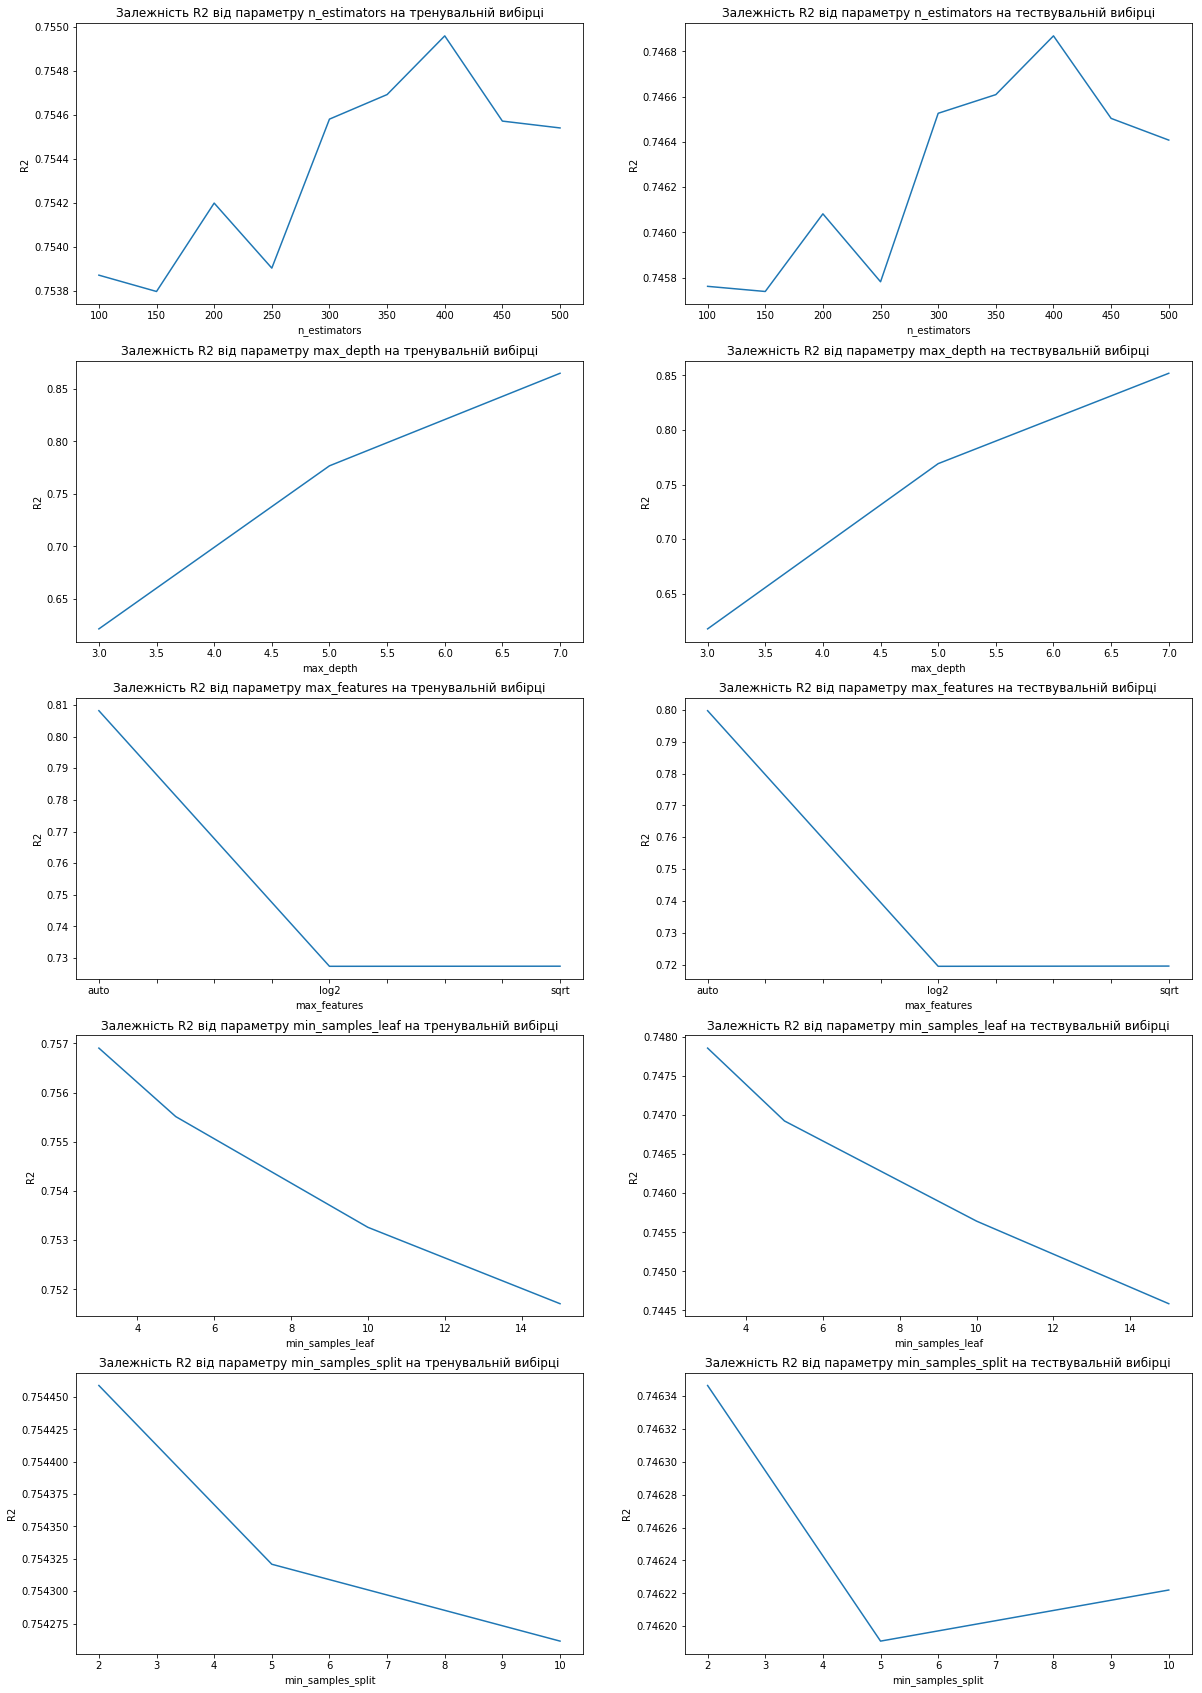

In [58]:
fig, axs = plt.subplots(nrows=len(parameters_names), ncols=2, figsize=(20, 30))

for idx, param in enumerate(parameters_names):
    plot_dependency(groupped_metrics_df, param, 'R2', axs[idx])

#### MAE

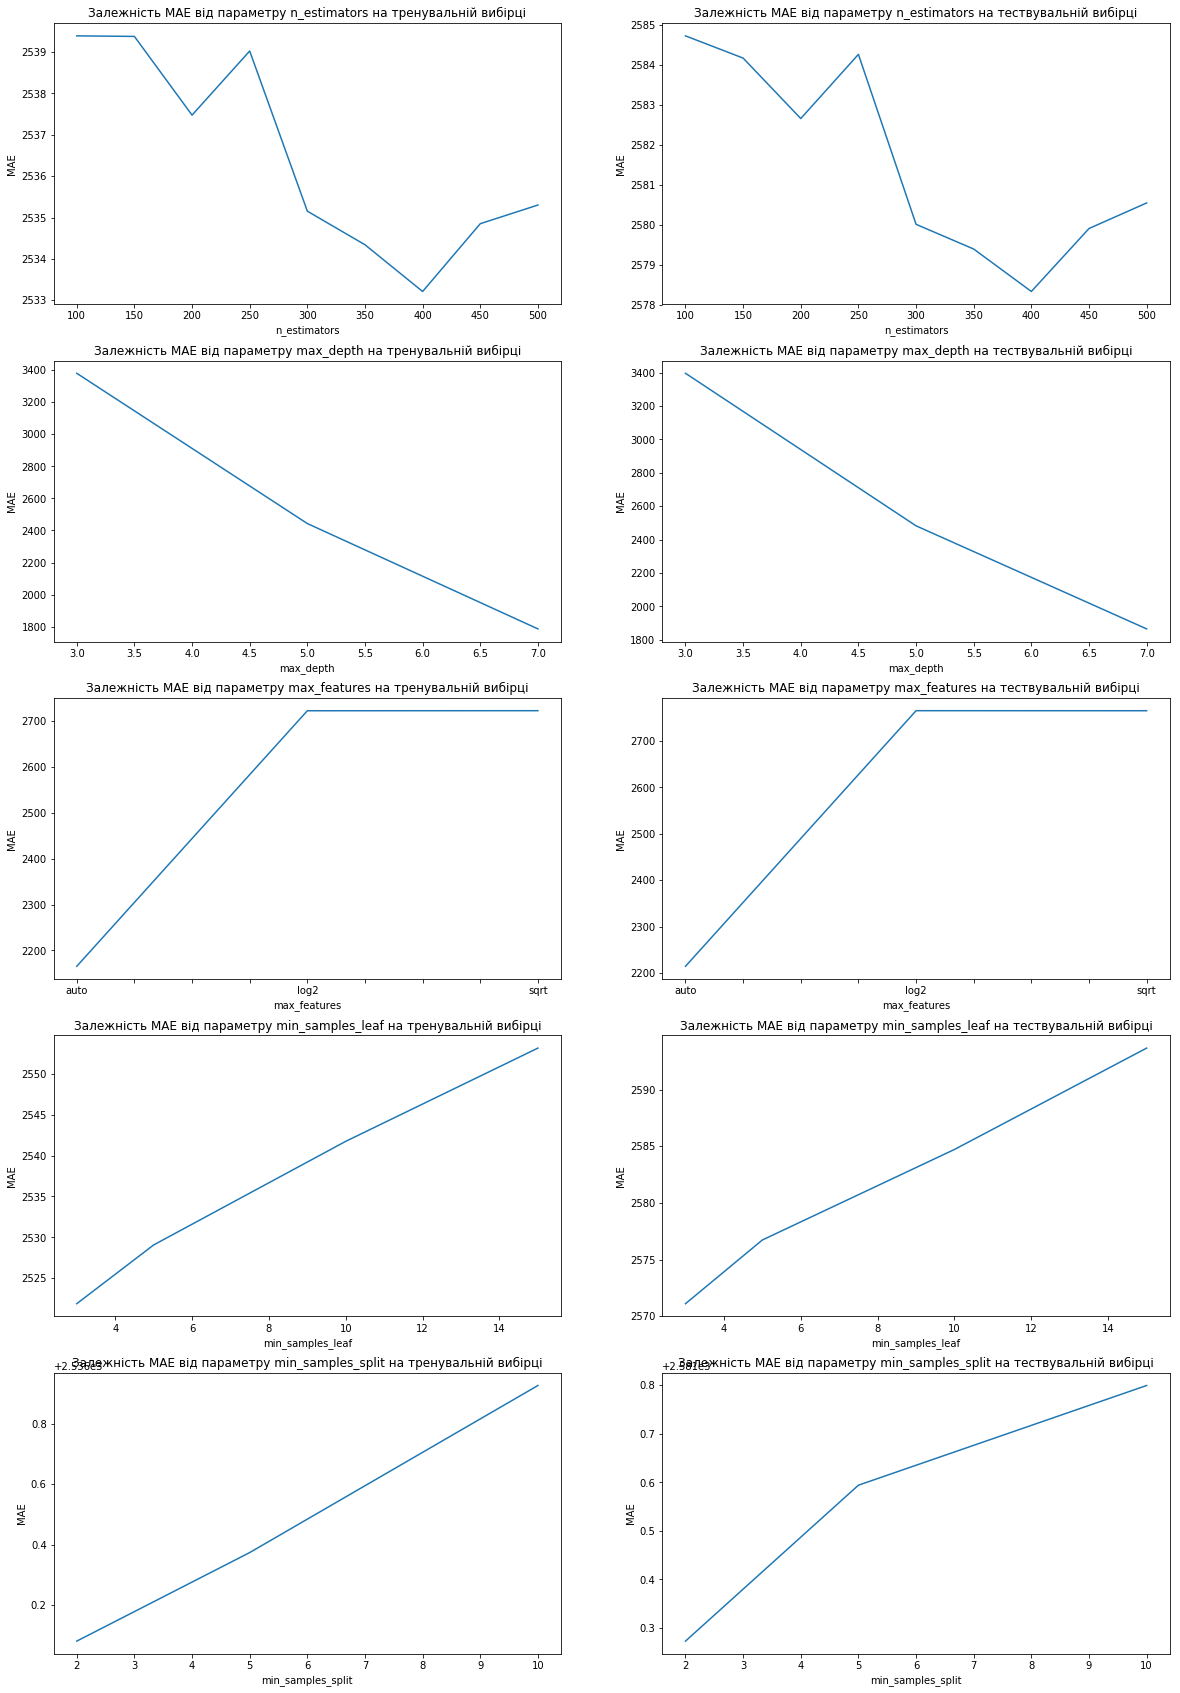

In [59]:
fig, axs = plt.subplots(nrows=len(parameters_names), ncols=2, figsize=(20, 30))

for idx, param in enumerate(parameters_names):
    plot_dependency(groupped_metrics_df, param, 'MAE', axs[idx])

#### MSE

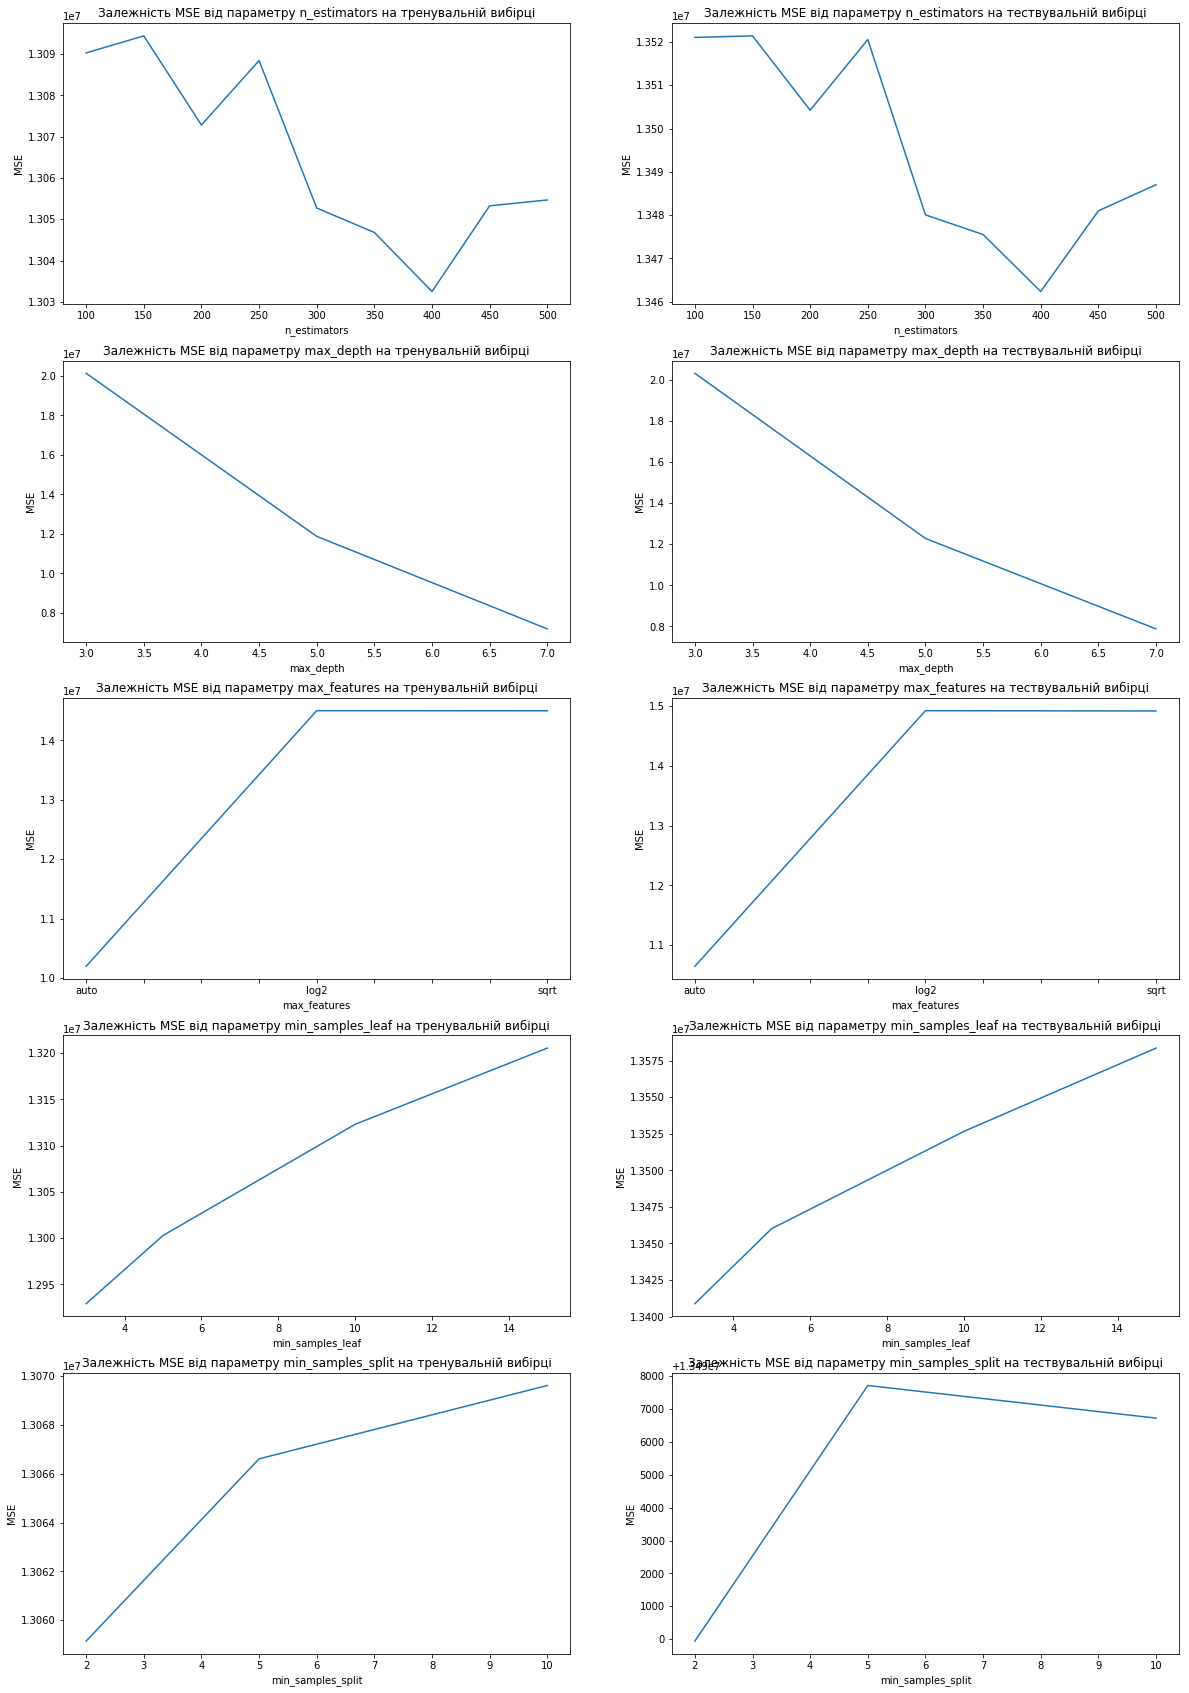

In [60]:
fig, axs = plt.subplots(nrows=len(parameters_names), ncols=2, figsize=(20, 30))

for idx, param in enumerate(parameters_names):
    plot_dependency(groupped_metrics_df, param, 'MSE', axs[idx])

#### MAPE

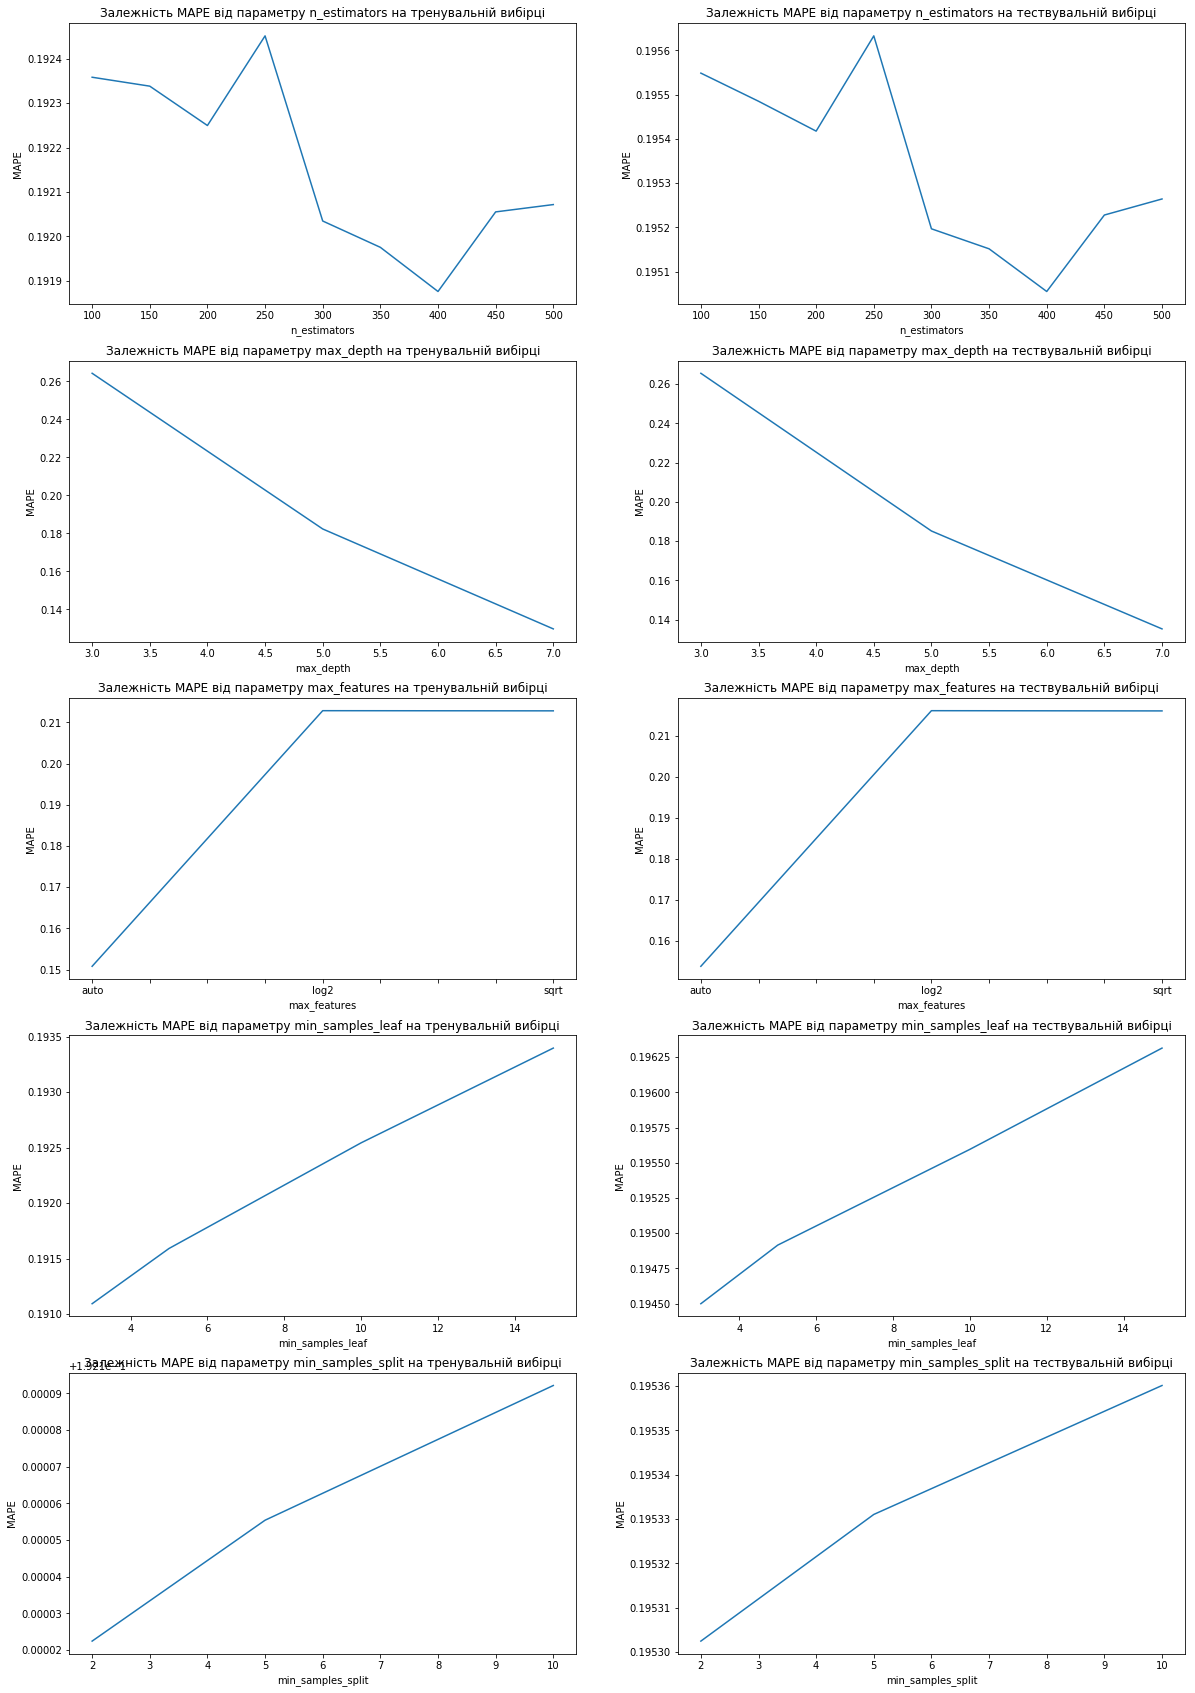

In [61]:
fig, axs = plt.subplots(nrows=len(parameters_names), ncols=2, figsize=(20, 30))

for idx, param in enumerate(parameters_names):
    plot_dependency(groupped_metrics_df, param, 'MAPE', axs[idx])

#### RMSE

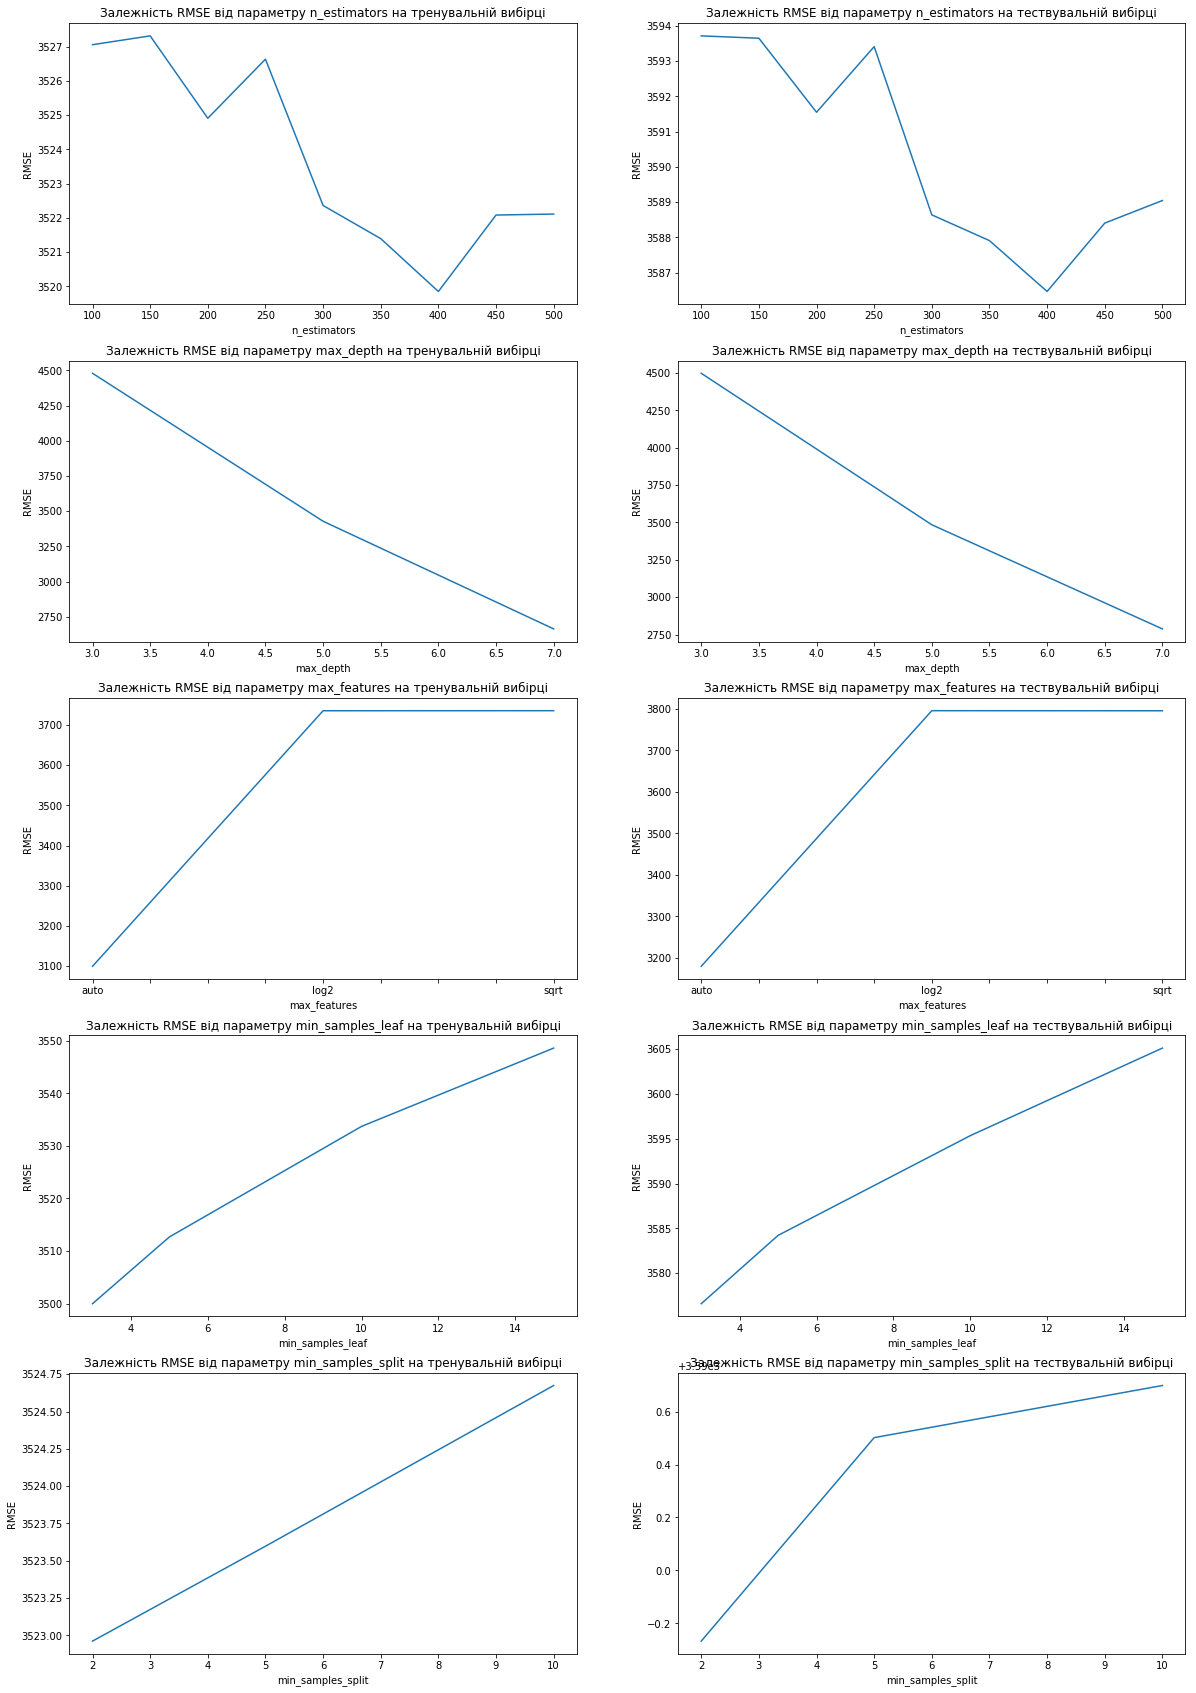

In [62]:
fig, axs = plt.subplots(nrows=len(parameters_names), ncols=2, figsize=(20, 30))

for idx, param in enumerate(parameters_names):
    plot_dependency(groupped_metrics_df, param, 'RMSE', axs[idx])

#### Згідно графіків отримуємо найкращі параметри: n_estimators-450, max_depth-7, max_features='auto', min_samples_leaf=3, min_samples_split-10

### Побудова прогнозу найкращою моделлю для holdout тесту

In [63]:
BEST_MODEL_PARAMS = {'n_estimators': 450, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3,
                    'min_samples_split': 10
                    }

In [64]:
train_data_prepared.head()

,Date,Store,Avg_Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,DateIndex,year,month,day
0,2010-02-05,1,22516.313699,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010-02-05,2010,2,5
1,2010-02-05,2,29273.828219,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False,A,202307,2010-02-05,2010,2,5
2,2010-02-05,3,7101.880308,45.71,2.572,NaN,NaN,NaN,NaN,NaN,214.424881,7.368,False,B,37392,2010-02-05,2010,2,5
3,2010-02-05,4,29248.546164,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,False,A,205863,2010-02-05,2010,2,5
4,2010-02-05,5,5115.695161,39.70,2.572,NaN,NaN,NaN,NaN,NaN,211.653972,6.566,False,B,34875,2010-02-05,2010,2,5


In [65]:
test_data.head()

,Store,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


In [66]:
test_data['year'] = pd.to_datetime(test_data.Date).dt.year
test_data['month'] = pd.to_datetime(test_data.Date).dt.month
test_data['day'] = pd.to_datetime(test_data.Date).dt.day

In [67]:
test_data[NUMERIC_FEATURES + CATEGORICAL_FEATURES].head()

,Temperature,Fuel_Price,CPI,Unemployment,Size,Type,year,month,day
0,55.32,3.386,223.462779,6.573,151315,A,2012,11,2
1,61.24,3.314,223.481307,6.573,151315,A,2012,11,9
2,52.92,3.252,223.512911,6.573,151315,A,2012,11,16
3,56.23,3.211,223.561947,6.573,151315,A,2012,11,23
4,52.34,3.207,223.610984,6.573,151315,A,2012,11,30


In [68]:
transformer = MinMaxScaler()
encoder = HelmertEncoder(cols=CATEGORICAL_FEATURES)

In [69]:
train_transformed = pd.DataFrame(transformer.fit_transform(train_data_prepared[NUMERIC_FEATURES]),
                                 columns=NUMERIC_FEATURES,
                                 index=train_data_prepared.index
                                )

train_encoded = pd.DataFrame(encoder.fit_transform(
    train_data_prepared[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES,
                             index=train_data_prepared.index
                            )



test_transformed = pd.DataFrame(transformer.transform(test_data[NUMERIC_FEATURES]),
                                 columns=NUMERIC_FEATURES,
                                 index=test_data.index
                                )

test_encoded = pd.DataFrame(encoder.transform(
    test_data[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES,
                             index=test_data.index
                            )

In [70]:
train_prepared_final = train_transformed.join(train_encoded).fillna(0)
test_prepared_final = test_transformed.join(test_encoded).fillna(0)

In [71]:
train_prepared_final.head()

,Temperature,Fuel_Price,CPI,Unemployment,Size,Type,year,month,day
0,0.434149,0.050100,0.840500,0.405118,0.630267,0.0,0.0,0.0,0.0
1,0.413405,0.050100,0.837102,0.426011,0.906277,0.0,0.0,0.0,0.0
2,0.467417,0.050100,0.873400,0.334388,0.013624,0.0,0.0,0.0,0.0
3,0.448337,0.063126,0.003737,0.454667,0.925525,0.0,0.0,0.0,0.0
4,0.408611,0.050100,0.846011,0.257523,0.000000,0.0,0.0,0.0,0.0


In [72]:
test_prepared_final.head()

,Temperature,Fuel_Price,CPI,Unemployment,Size,Type,year,month,day
0,0.561448,0.457916,0.962735,0.258194,0.630267,0.0,0.0,0.0,0.0
1,0.619374,0.421844,0.962918,0.258194,0.630267,0.0,0.0,0.0,0.0
2,0.537965,0.390782,0.963231,0.258194,0.630267,0.0,0.0,0.0,0.0
3,0.570352,0.370240,0.963716,0.258194,0.630267,0.0,0.0,0.0,0.0
4,0.532290,0.368236,0.964200,0.258194,0.630267,0.0,0.0,0.0,0.0


In [73]:
train_prepared_final.shape, train_data_prepared.shape

((6435, 9), (6435, 19))

In [74]:
train_prepared_final = train_prepared_final.join(train_data_prepared[['Date','Avg_Weekly_Sales']])

In [75]:
train_prepared_final.head(2)

,Temperature,Fuel_Price,CPI,Unemployment,Size,Type,year,month,day,Date,Avg_Weekly_Sales
0,0.434149,0.0501,0.840500,0.405118,0.630267,0.0,0.0,0.0,0.0,2010-02-05,22516.313699
1,0.413405,0.0501,0.837102,0.426011,0.906277,0.0,0.0,0.0,0.0,2010-02-05,29273.828219


In [76]:
test_prepared_final = test_prepared_final.join(test_data['Date'])

In [77]:
model_final = RandomForestRegressor(**BEST_MODEL_PARAMS)

In [78]:
model_final.fit(train_prepared_final[NUMERIC_FEATURES + CATEGORICAL_FEATURES], 
                train_prepared_final['Avg_Weekly_Sales']
               )

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=10,
                      n_estimators=450)

In [79]:
final_model_train_metrics = {}

for metric_name, metric in METRICS_MAPPING.items():
    final_model_train_metrics[metric_name] = metric(
        train_prepared_final['Avg_Weekly_Sales'],
        model_final.predict(train_prepared_final[NUMERIC_FEATURES + CATEGORICAL_FEATURES])
    )

In [80]:
pd.DataFrame([final_model_train_metrics])

,R2,MAE,MAPE,MSE,RMSE
0,0.908859,1358.612075,0.093506,4.847293e+06,2201.656913


In [81]:
train_prepared_final['predict'] = model_final.predict(
    train_prepared_final[NUMERIC_FEATURES + CATEGORICAL_FEATURES])

In [82]:
train_prepared_final.head()

,Temperature,Fuel_Price,CPI,Unemployment,Size,Type,year,month,day,Date,Avg_Weekly_Sales,predict
0,0.434149,0.050100,0.840500,0.405118,0.630267,0.0,0.0,0.0,0.0,2010-02-05,22516.313699,21596.651229
1,0.413405,0.050100,0.837102,0.426011,0.906277,0.0,0.0,0.0,0.0,2010-02-05,29273.828219,26366.336169
2,0.467417,0.050100,0.873400,0.334388,0.013624,0.0,0.0,0.0,0.0,2010-02-05,7101.880308,6476.872153
3,0.448337,0.063126,0.003737,0.454667,0.925525,0.0,0.0,0.0,0.0,2010-02-05,29248.546164,25796.403944
4,0.408611,0.050100,0.846011,0.257523,0.000000,0.0,0.0,0.0,0.0,2010-02-05,5115.695161,4709.495992


In [83]:
test_prepared_final['predict'] = model_final.predict(
    test_prepared_final[NUMERIC_FEATURES + CATEGORICAL_FEATURES])

In [84]:
test_prepared_final.head()

,Temperature,Fuel_Price,CPI,Unemployment,Size,Type,year,month,day,Date,predict
0,0.561448,0.457916,0.962735,0.258194,0.630267,0.0,0.0,0.0,0.0,2012-11-02,22182.460874
1,0.619374,0.421844,0.962918,0.258194,0.630267,0.0,0.0,0.0,0.0,2012-11-09,22176.154647
2,0.537965,0.390782,0.963231,0.258194,0.630267,0.0,0.0,0.0,0.0,2012-11-16,22662.840699
3,0.570352,0.370240,0.963716,0.258194,0.630267,0.0,0.0,0.0,0.0,2012-11-23,22670.895386
4,0.532290,0.368236,0.964200,0.258194,0.630267,0.0,0.0,0.0,0.0,2012-11-30,23150.330461


In [85]:
train_prepared_final['Date_index'] = pd.DatetimeIndex(train_prepared_final['Date'])

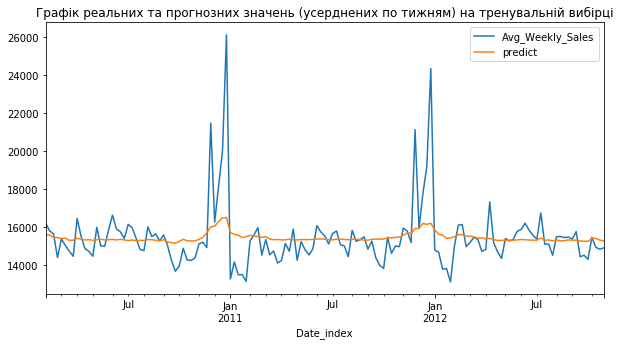

In [86]:
train_prepared_final.set_index('Date_index')[['Avg_Weekly_Sales', 'predict']].resample('W').mean().plot(
    title='Графік реальних та прогнозних значень (усерднених по тижням) на тренувальній вибірці',
    figsize=(10, 5));

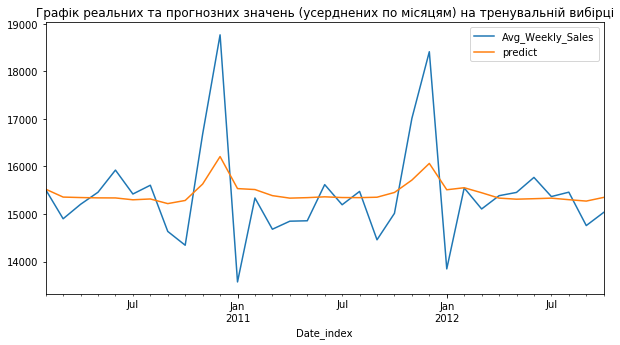

In [87]:
train_prepared_final.set_index('Date_index')[['Avg_Weekly_Sales', 'predict']].resample('M').mean().plot(
    title='Графік реальних та прогнозних значень (усерднених по місяцям) на тренувальній вибірці',
    figsize=(10, 5));

In [88]:
test_prepared_final['Date_index'] = pd.DatetimeIndex(test_prepared_final['Date'])

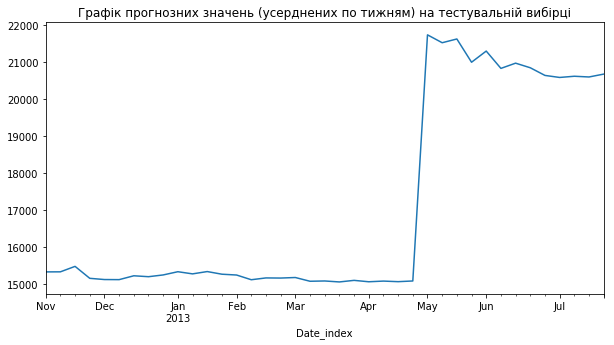

In [89]:
test_prepared_final.set_index('Date_index')['predict'].resample('W').mean().plot(
    title='Графік прогнозних значень (усерднених по тижням) на тестувальній вибірці',
    figsize=(10, 5));

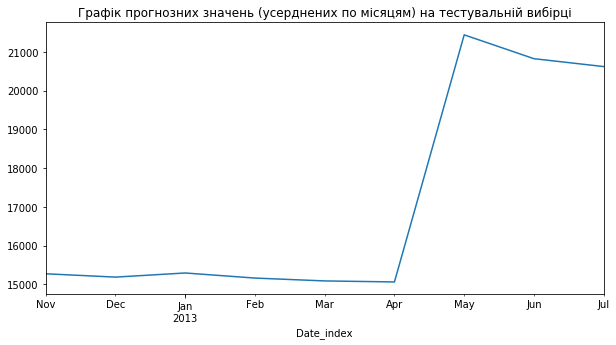

In [90]:
test_prepared_final.set_index('Date_index')['predict'].resample('M').mean().plot(
    title='Графік прогнозних значень (усерднених по місяцям) на тестувальній вибірці',
    figsize=(10, 5));

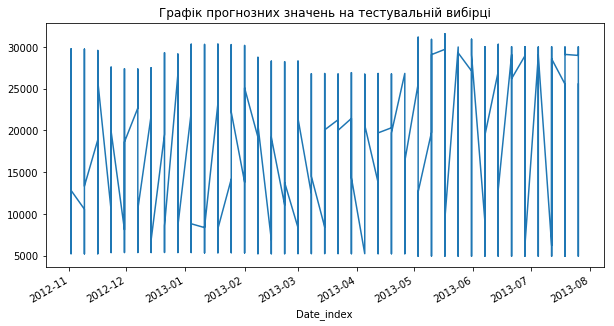

In [91]:
test_prepared_final.set_index('Date_index')['predict'].plot(
    title='Графік прогнозних значень на тестувальній вибірці',
    figsize=(10, 5));